# SCRAP
**Seismic collapse response prediction of steel moment resisting frames**


The following notebook contains the code for SCRAP, a Machine Learning model to predict the seismic risk of a building. 

**Table of Contents**
1. [Data Analysis](#data-analysis)
2. [ECDF](#ecdf)
3. [Anticlustering](#anticlustering)
4. [Models](#models)
    * [Ridge Regression](#ridge-regression)
    * [MLP](#mlp)
    * [Gradient Boosting](#gradient-boosting)
5. [Results](#results)


# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
import shap
shap.initjs()

# Data Analysis <a class="anchor" id="data-analysis"></a>

### Importing the data

In [2]:
df_old = pd.read_csv("4s_data.csv")
df_train = pd.read_csv("4S_2023-12-05.csv")
df_test1 = pd.read_csv("4S_2023-12-14_test_final.csv")
df_test2 = pd.read_csv("4S_2023-12-05_test_2.csv")

df_train_ACDC_1b = pd.read_csv("4s_acdc_h_adapt_1b.csv")
df_train_ACDC_5b = pd.read_csv("4s_acdc_h_adapt_5b.csv")
df_train_ACDC_silverman = pd.read_csv("4s_acdc_h_silverman.csv")

no_scaling_columns = ['da5_75', 'da5_95', 'fiv3_sa_avg', 'sa_ratio', 'sat1_col']
order_columns = df_train.columns

df1_train = df_train[no_scaling_columns]  
df2_train = df_train.drop(columns=no_scaling_columns).div(df_train['1.3'], axis=0)

df1_test1 = df_test1[no_scaling_columns]  
df2_test1 = df_test1.drop(columns=no_scaling_columns).div(df_test1['1.3'], axis=0)

df1_test2 = df_test2[no_scaling_columns]  
df2_test2 = df_test2.drop(columns=no_scaling_columns).div(df_test2['1.3'], axis=0)

df_train_scaled = pd.concat([df2_train, df1_train], axis=1)

df_train_scaled_ACDC_1b = pd.concat([df_train_scaled, df_train_ACDC_1b], axis=0)[order_columns]
df_train_scaled_ACDC_5b = pd.concat([df_train_scaled, df_train_ACDC_5b], axis=0)[order_columns]
df_train_scaled_ACDC_silverman = pd.concat([df_train_scaled, df_train_ACDC_silverman], axis=0)[order_columns]

df_test1_scaled = pd.concat([df1_test1, df2_test1], axis=1)[order_columns]
df_test2_scaled = pd.concat([df1_test2, df2_test2], axis=1)[order_columns]

y_pred_test1_Nenad = df_test1['sat1_col_hat']

In [3]:
df_train.describe().iloc[1:3,-7:]

,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col
mean,0.180931,26.678938,46.458369,87.521647,0.495606,1.707512,1.211932
std,0.064593,23.245931,37.836278,31.033635,0.062701,0.601435,0.535962


In [4]:
df_train_ACDC_1b.describe().iloc[1:3,-7:]

,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col
mean,0.550464,29.29473,39.882924,260.641376,0.486498,2.174276,2.015073
std,0.278728,85.63382,86.713950,146.059787,0.064499,0.854513,0.923380


In [5]:
df_train_ACDC_5b.describe().iloc[1:3,-7:]

,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col
mean,0.521494,51.308193,56.007273,246.876336,0.494541,2.289148,2.015042
std,0.245263,231.304896,186.192615,111.389258,0.069293,0.922856,0.923284


In [6]:
df_train_ACDC_silverman.describe().iloc[1:3,-7:]

,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col
mean,0.527685,35.067035,38.237140,246.629995,0.488405,2.269503,2.014987
std,0.246326,158.661358,95.515257,113.385791,0.070575,0.956507,0.923200


In [7]:
df_test1.describe().iloc[1:3,-7:]

,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col,sat1_col_hat
mean,18.475386,36.392963,18.033931,0.527791,1.595773,1.102566,1.10882
std,13.317212,27.488704,26.127726,0.092661,0.583154,0.438803,0.40544


In [8]:
df_test2.describe().iloc[1:3,-7:]

,sa_avg,da5_75,da5_95,fiv3,fiv3_sa_avg,sa_ratio,sat1_col
mean,0.011682,11.078911,22.498519,5.498966,0.495743,2.082097,1.029385
std,0.039766,11.879844,23.246346,18.675696,0.092378,0.693966,0.526562


### Visualization of all the ground motions

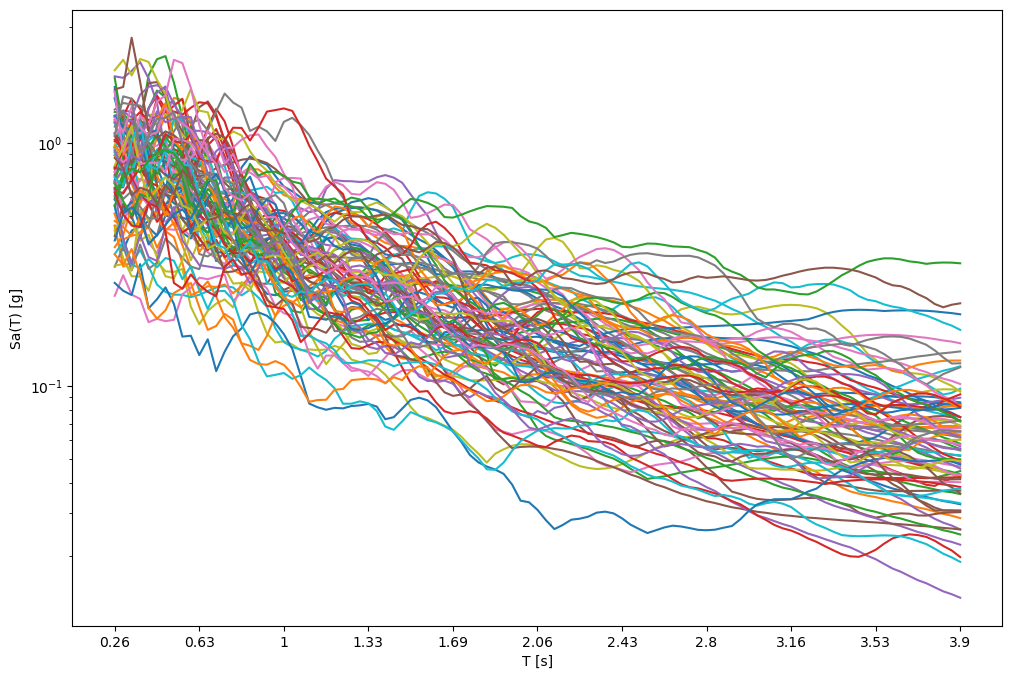

In [9]:
plt.figure(figsize=(12,8))
for i in range(df_train.iloc[:, :-7].shape[0]):
    plt.plot(df_train.columns[:-7],df_train.iloc[i, :-7])
plt.ylabel("Sa(T) [g]")
plt.yscale('log')
plt.xlabel("T [s]")
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

### Reparition of the collapse capacity

Train set

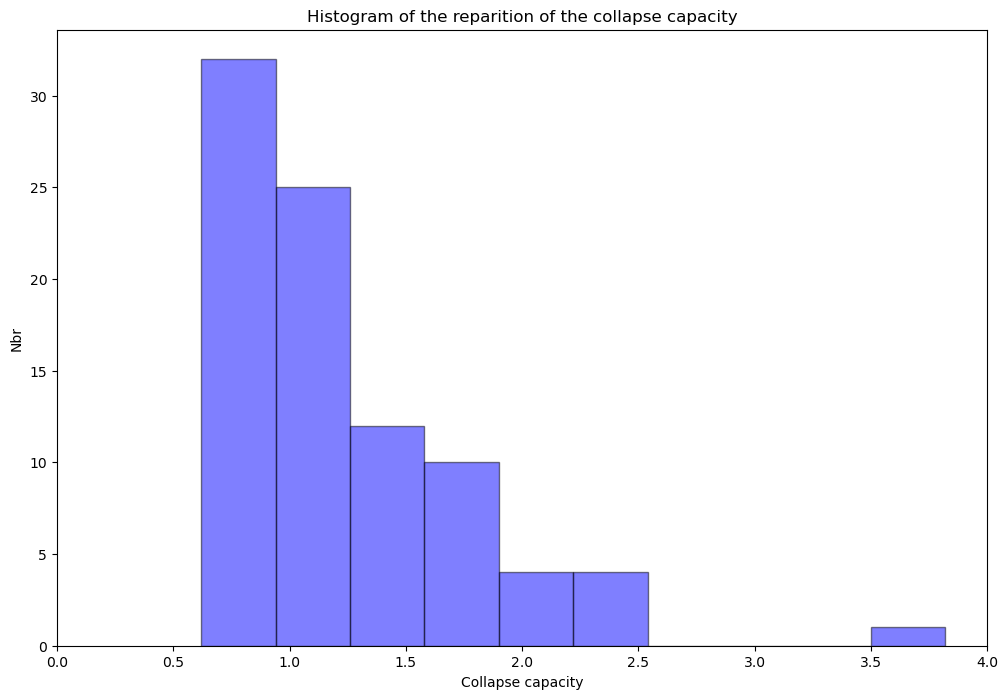

In [10]:
plt.figure(figsize=(12,8))
plt.hist(df_train['sat1_col'], bins=10, color='blue', edgecolor='black',alpha=0.5)
plt.xlim(0,4)
plt.xlabel('Collapse capacity')
plt.ylabel('Nbr')
plt.title('Histogram of the reparition of the collapse capacity')
plt.show()

Test set 1 and Test set 2

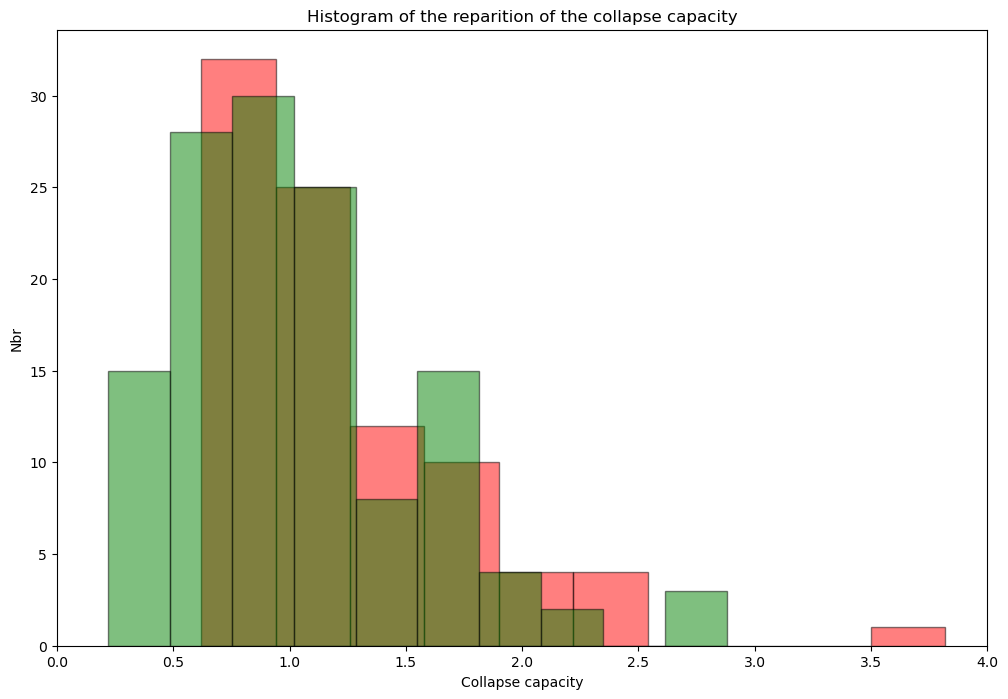

In [11]:
plt.figure(figsize=(12,8))
plt.hist(df_train['sat1_col'], bins=10, color='red', edgecolor='black',alpha=0.5)
plt.hist(df_test2['sat1_col'], bins=10, color='green', edgecolor='black',alpha=0.5)
plt.xlim(0,4)
plt.xlabel('Collapse capacity')
plt.ylabel('Nbr')
plt.title('Histogram of the reparition of the collapse capacity')
plt.show()

Augmented Train set

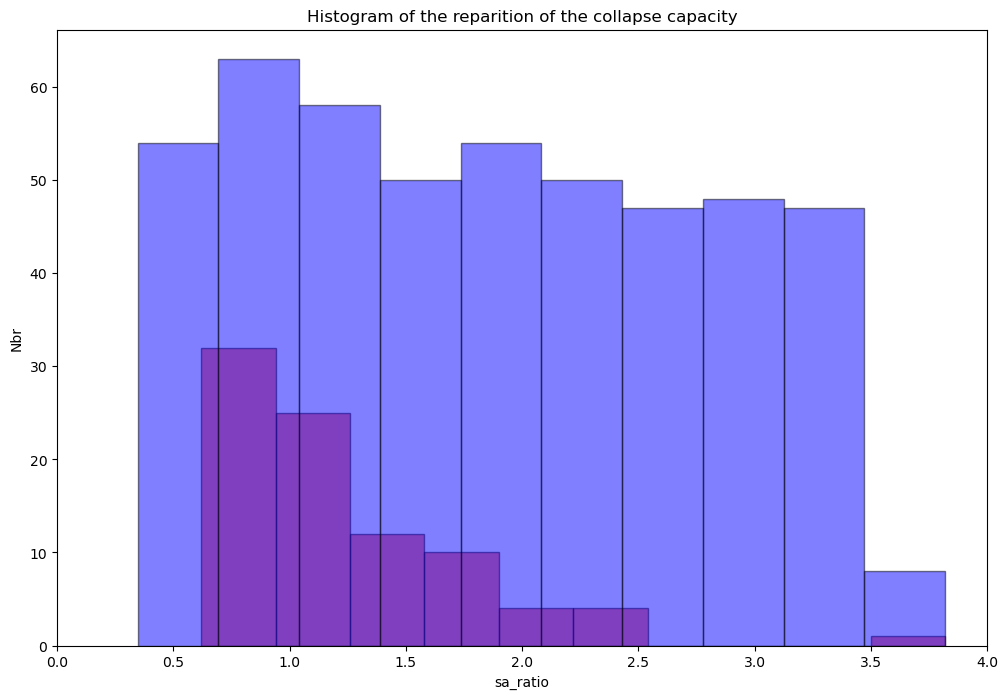

In [12]:
plt.figure(figsize=(12,8))
plt.hist(df_train_scaled['sat1_col'], bins=10, color='red', edgecolor='black',alpha=0.5)
plt.hist(df_train_scaled_ACDC_1b['sat1_col'], bins=10, color='blue', edgecolor='black',alpha=0.5)
#plt.hist(df_train_scaled_ACDC_5b['sa_ratio'], bins=10, color='orange', edgecolor='black',alpha=0.5)
#plt.hist(df_train_scaled_ACDC_silverman['sa_ratio'], bins=10, color='green', edgecolor='black',alpha=0.5)
plt.xlim(0,4)
plt.xlabel('sa_ratio')
plt.ylabel('Nbr')
plt.title('Histogram of the reparition of the collapse capacity')
plt.show()

### Main Features correlation and distribution

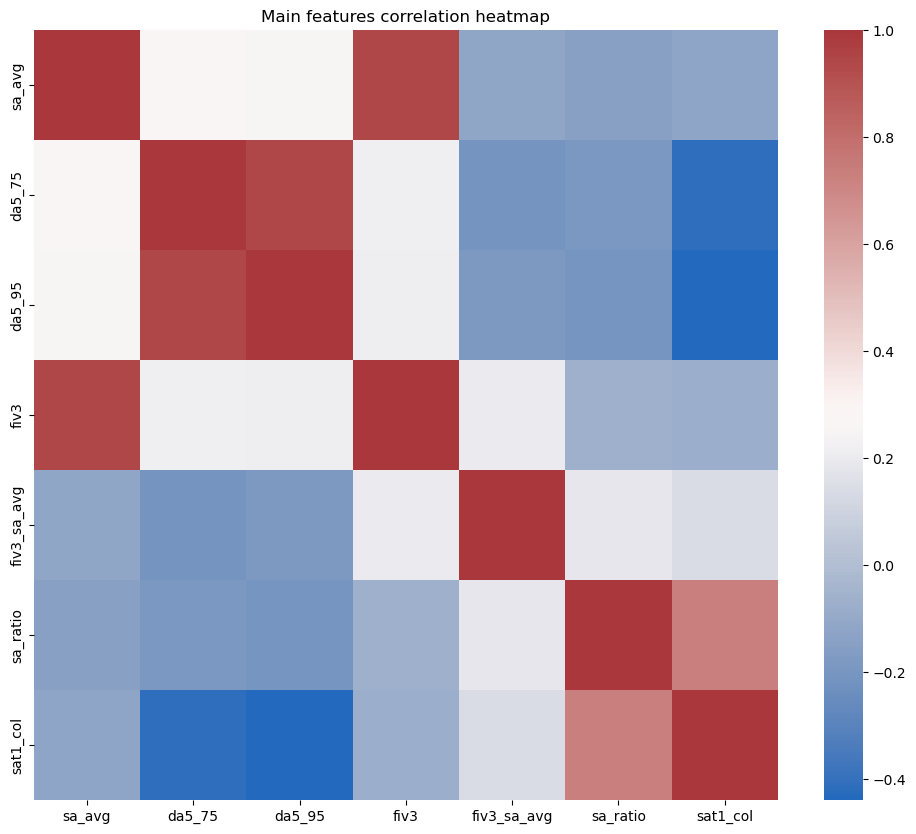

In [13]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))

sns.heatmap(df_train[['sa_avg', 'da5_75', 'da5_95', 'fiv3',
                'fiv3_sa_avg', 'sa_ratio', 'sat1_col']].corr(), cmap='vlag')
plt.title('Main features correlation heatmap')
plt.show()

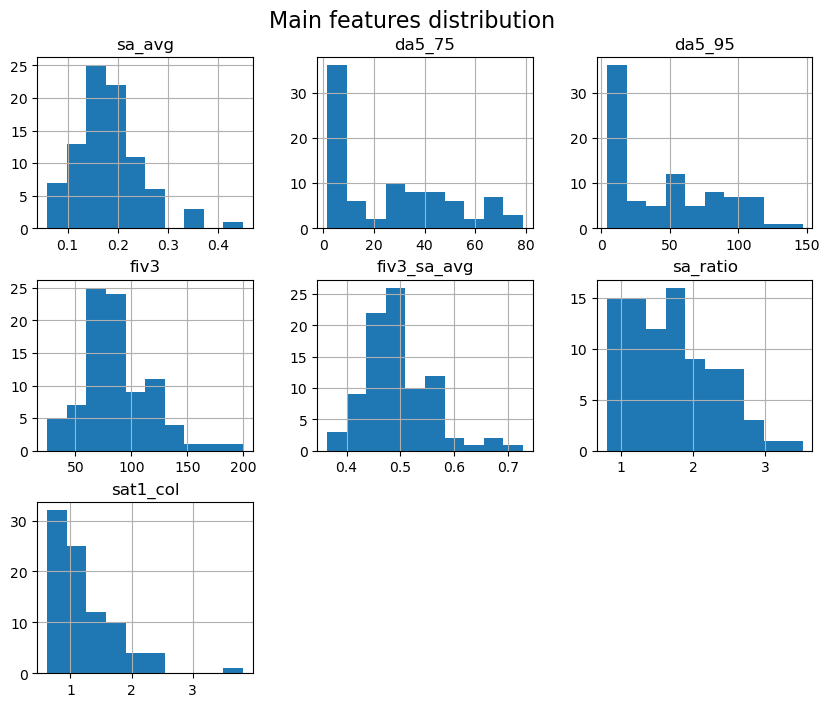

In [14]:
df_train.iloc[:,-7:].hist(figsize=(10, 8))
plt.suptitle('Main features distribution', y=0.94, fontsize=16)
plt.show()

# ECDF <a class="anchor" id="ecdf"></a>
Preparing the code to run the ECDF function

In [15]:
def ECDF():

    Collapse_cap = np.sort(y_test1)
    Proba0 = 1/len(Collapse_cap)
    Proba = 1/len(Collapse_cap)
    
    Collapse_cap2 = np.sort(y_test2)
    Proba02 = 1/len(Collapse_cap2)
    Proba2 = 1/len(Collapse_cap2)

    Collapse_cap_pred = np.sort(y_pred_test1)
    Proba_pred0 = 1/len(Collapse_cap_pred)
    Proba_pred = 1/len(Collapse_cap_pred)
    
    Collapse_cap_pred2 = np.sort(y_pred_test2)
    Proba_pred02 = 1/len(Collapse_cap_pred2)
    Proba_pred2 = 1/len(Collapse_cap_pred2)
    
    Collapse_cap_Nenad = np.sort(y_pred_test1_Nenad)
    Proba_pred0N = 1/len(Collapse_cap_Nenad)
    Proba_predN = 1/len(Collapse_cap_Nenad)
    
    ECDF_true = [Proba0]
    ECDF_true2 = [Proba02]
    ECDF_pred = [Proba_pred0]
    ECDF_pred2 = [Proba_pred02]
    ECDF_pred_Nenad = [Proba_pred0N]

    for i in range(1,len(Collapse_cap)): #Test set 1
        Proba = Proba + Proba0
        Proba_pred = Proba_pred + Proba_pred0
        Proba_predN = Proba_predN + Proba_pred0N
        ECDF_true.append(Proba)
        ECDF_pred.append(Proba_pred)
        ECDF_pred_Nenad.append(Proba_predN)
        
    for i in range(1,len(Collapse_cap2)): #Test set 2
        Proba2 = Proba2 + Proba02
        Proba_pred2 = Proba_pred2 + Proba_pred02
        ECDF_true2.append(Proba2)
        ECDF_pred2.append(Proba_pred2)
        
    plt.plot(Collapse_cap,ECDF_true,label="True (Set1)")
    plt.plot(Collapse_cap_pred,ECDF_pred,label="Predicted (Set1)")
    plt.plot(Collapse_cap_Nenad,ECDF_pred_Nenad,label="Predicted - classification (Set1)")
    #plt.plot(Collapse_cap2,ECDF_true2,label="True (Set2)")
    #plt.plot(Collapse_cap_pred2,ECDF_pred2,label="Predicted (Set2)")
    plt.xlabel("Collapse capacity = Sa(T1) at collapse")
    plt.ylabel("ECDF")
    plt.legend()
    #plt.xlim(0.4,2)
    plt.grid(visible=True)
    plt.show()

# Anticlustering <a class="anchor" id="anticlustering"></a>

In [16]:
from anti_clustering import ExchangeHeuristicAntiClustering
nbre_iter = 100

selected_columns = ['da5_75','da5_95','fiv3_sa_avg','sa_ratio']

algorithm = ExchangeHeuristicAntiClustering()
nbre_groups = [1,2,3,4,5,6]

List_trainset = [[] for s in range(nbre_iter)]

for i in range(nbre_iter):
    for K in (nbre_groups):
        algorithm = ExchangeHeuristicAntiClustering()
        df = algorithm.run(
            df=df_train,
            numerical_columns=list(df_train[selected_columns].columns),
            categorical_columns=None,
            num_groups=K,
            destination_column='Cluster'
        )
        
        List_trainset[i].append(df[df['Cluster'] == 0].drop(columns=['Cluster']))

Computing all models with all the different train set

In [17]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler

MSE1 = np.zeros((len(List_trainset),len(List_trainset[0])))
MSE2 = np.zeros((len(List_trainset),len(List_trainset[0])))
Number_of_data = []
for i in range(len(List_trainset)):
    for j in range(len(List_trainset[0])):
        scaler = MinMaxScaler()
        X_train=List_trainset[i][j].iloc[:,:-1]
        y=List_trainset[i][j].iloc[:,-1]

        # Fit and transform the training data
        X_train_scaled_np = scaler.fit_transform(X_train)
        X = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)

        X_test1 = df_test1.iloc[:, :-2]
        X_test2 = df_test2.iloc[:, :-1]
        X_test1_scaled_np = scaler.transform(X_test1)
        X_test2_scaled_np = scaler.transform(X_test2)
        X_test1 = pd.DataFrame(X_test1_scaled_np, columns=X_test1.columns, index=X_test1.index)
        X_test2 = pd.DataFrame(X_test2_scaled_np, columns=X_test2.columns, index=X_test2.index)

        y_test1 = df_test1.iloc[:, -2]
        y_test2 = df_test2.iloc[:, -1]
        if i ==0:
            Number_of_data.append(X.shape[0])
        lin_reg = Ridge()

        param_grid = {
            'alpha': np.logspace(-4, 0, 30),
        }

        grid_search = GridSearchCV(lin_reg, param_grid, cv=5)

        grid_search.fit(X, y)

        best_params = grid_search.best_params_

        lin_reg = Ridge(**best_params)
        lin_reg.fit(X, y)

        y_pred_test1 = lin_reg.predict(X_test1)
        y_pred_test2 = lin_reg.predict(X_test2)

        MSE1[i][j] = (mean_squared_error(y_test1, y_pred_test1))
        MSE2[i][j] = (mean_squared_error(y_test2, y_pred_test2))

Plotting the result

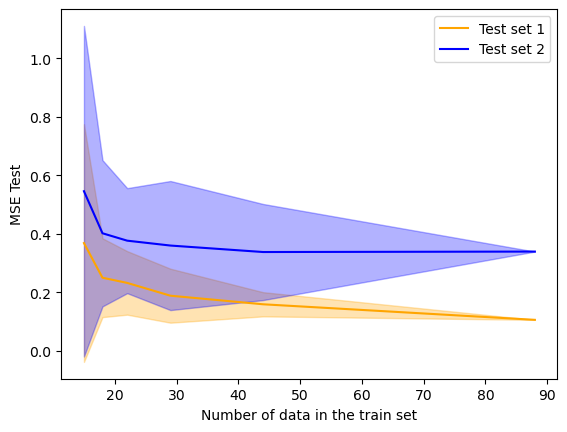

In [18]:
MEAN_MSE_1 = np.mean(MSE1,axis=0)
MEAN_MSE_2 = np.mean(MSE2,axis=0)

STD_MSE_1 = np.std(MSE1,axis=0)
STD_MSE_2 = np.std(MSE2,axis=0)

Number_of_data[:6]

plt.plot(Number_of_data[:6],MEAN_MSE_1, label="Test set 1",color='orange')
plt.fill_between(Number_of_data[:6],(MEAN_MSE_1-STD_MSE_1),(MEAN_MSE_1+STD_MSE_1),color="orange",alpha=0.3)

plt.plot(Number_of_data[:6],np.mean(MSE2,axis=0), label="Test set 2",color='blue')
plt.fill_between(Number_of_data[:6],(MEAN_MSE_2-STD_MSE_2),(MEAN_MSE_2+STD_MSE_2),color="blue",alpha=0.3)

plt.ylabel("MSE Test")
plt.xlabel("Number of data in the train set")
plt.legend()
plt.show()

# Models <a class="anchor" id="models"></a>

Function to select the data between the different augumented datasets

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# augment: yes or no, ACDC: 1b, 5b or silverman
def choice_data(augment,ACDC):
    scaler = MinMaxScaler()
    if augment == "yes":
        if ACDC == "1b":
            Data = df_train_scaled_ACDC_1b
        elif ACDC == "5b":
            Data = df_train_scaled_ACDC_5b
        elif ACDC == "silverman" :
            Data = df_train_scaled_ACDC_silverman
        else:
            print("error in the ACDC entry") 
            
        X_train = Data.iloc[:, :-1]
        y = Data.iloc[:, -1]
        X_train_scaled_np = scaler.fit_transform(X_train)
        X = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)
        
        X_test1 = df_test1_scaled.iloc[:, :-1]
        X_test2 = df_test2_scaled.iloc[:, :-1]
        X_test1_scaled_np = scaler.transform(X_test1)
        X_test2_scaled_np = scaler.transform(X_test2)
        X_test1 = pd.DataFrame(X_test1_scaled_np, columns=X_test1.columns, index=X_test1.index)
        X_test2 = pd.DataFrame(X_test2_scaled_np, columns=X_test2.columns, index=X_test2.index)

        y_test1 = df_test1_scaled.iloc[:, -1]
        y_test2 = df_test2_scaled.iloc[:, -1]
        
        return X,y,X_test1,X_test2,y_test1,y_test2            
       
    
    elif augment == "no":
        X_train = df_train.iloc[:, :-1]
        y = df_train.iloc[:, -1]
        
        X_train_scaled_np = scaler.fit_transform(X_train)
        X = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)
        X_test1 = df_test1[order_columns].iloc[:, :-1]
        X_test2 = df_test2.iloc[:, :-1]
        X_test1_scaled_np = scaler.transform(X_test1)
        X_test2_scaled_np = scaler.transform(X_test2)
        X_test1 = pd.DataFrame(X_test1_scaled_np, columns=X_test1.columns, index=X_test1.index)
        X_test2 = pd.DataFrame(X_test2_scaled_np, columns=X_test2.columns, index=X_test2.index)

        y_test1 = df_test1[order_columns].iloc[:, -1]
        y_test2 = df_test2.iloc[:, -1]
        
        return X,y,X_test1,X_test2,y_test1,y_test2
    
    else:
        print("error in the scaling entry")

In [20]:
X,y,X_test1,X_test2,y_test1,y_test2 = choice_data("yes","5b")

## Ridge regression <a class="anchor" id="ridge-regression"></a>

In [21]:
from sklearn.linear_model import Ridge

lin_reg = Ridge()

param_grid = {
    'alpha': np.logspace(-4, 1, 30),
}

grid_search = GridSearchCV(lin_reg, param_grid, cv=5)

grid_search.fit(X, y)

best_params_ridge = grid_search.best_params_
print(f'Best parameters :{best_params_ridge}')

Best parameters :{'alpha': 0.4175318936560405}


### Testing

In [22]:
lin_reg = Ridge(**best_params_ridge)
lin_reg.fit(X, y)

y_pred_test1 = lin_reg.predict(X_test1)
y_pred_test2 = lin_reg.predict(X_test2)

MSE_Test_RIDGE1 = mean_squared_error(y_test1, y_pred_test1)
MSE_Test_RIDGE2 = mean_squared_error(y_test2, y_pred_test2)

print(f"RIDGE Mean Squared Error test1: {round(MSE_Test_RIDGE1,3)}")      
print(f"RIDGE Mean Squared Error test2: {round(MSE_Test_RIDGE2,3)}")  

RIDGE Mean Squared Error test1: 0.257
RIDGE Mean Squared Error test2: 0.672


Test Set 1

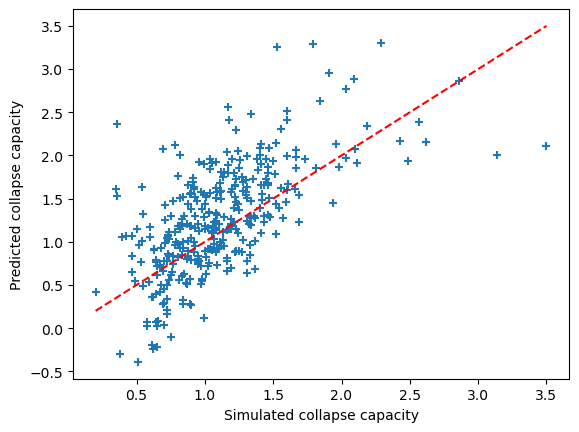

In [23]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

Test set 2

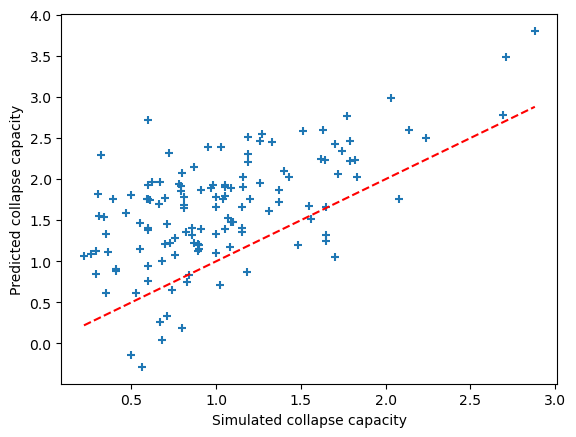

In [24]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

ECDF plot

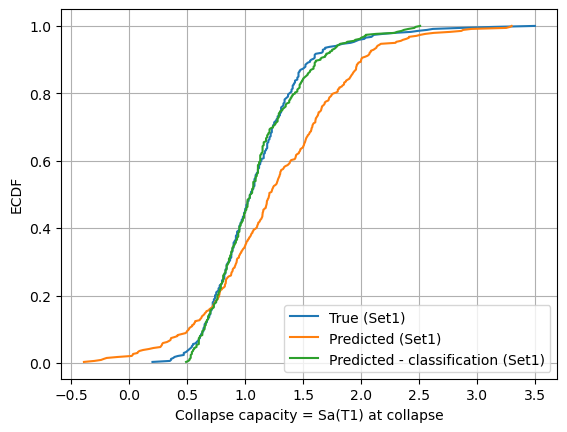

In [25]:
ECDF()

SHAP analysis

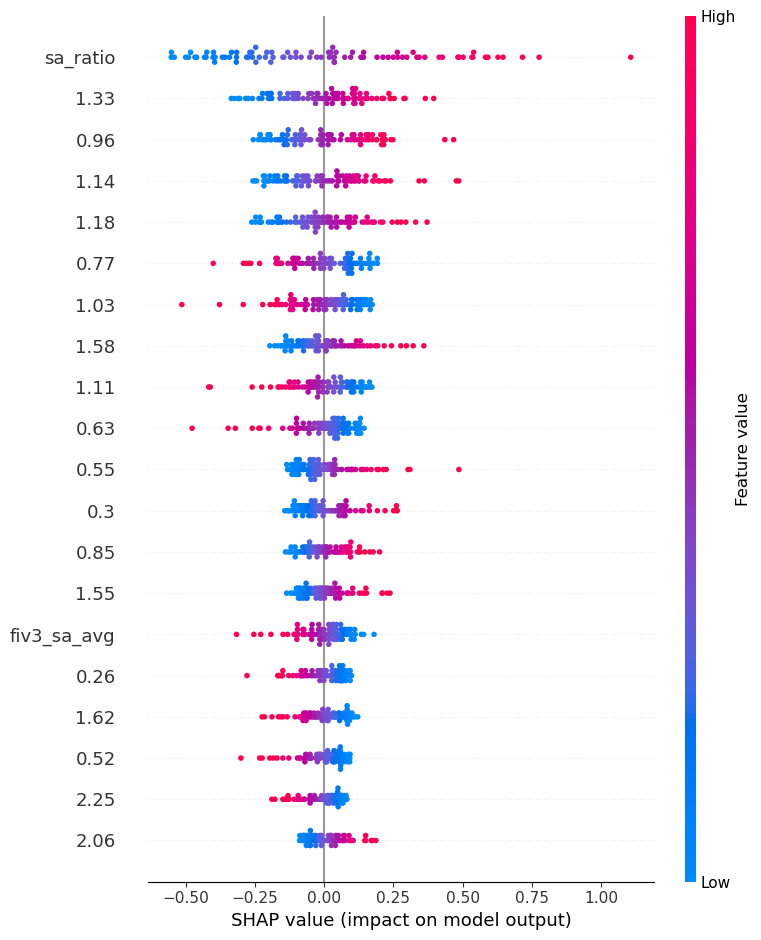

In [26]:
explainer = shap.Explainer(lin_reg, X[0:88])
shap_values = explainer(X[0:88])
shap.summary_plot(shap_values)


## MLP <a class="anchor" id="mlp"></a>

In [27]:
from sklearn.model_selection import train_test_split
def split(X,y,SEED,size):
    X_train,X_valid = train_test_split(X, test_size=size, random_state=SEED)
    y_train,y_valid = train_test_split(y, test_size=size, random_state=SEED)
    return X_train,X_valid,y_train,y_valid

MLP Mean Squared Error validation: 0.147
MLP Mean Squared Error test1: 0.169
MLP Mean Squared Error test2: 0.271


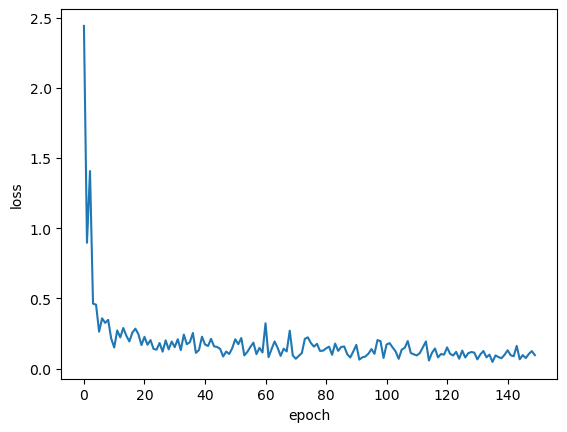

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
X_train = X.to_numpy()
y_train = y.to_numpy()
SEED = 43

X_train_split,X_valid_split,y_train_split,y_valid_split = split(X_train,y_train,SEED,0.2)

np.random.seed(SEED)
torch.manual_seed(SEED)

class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

hidden_size = 64 
output_size = 1
max_iterations = 10000

MSE_Train_MLP = np.zeros((1,max_iterations))
MSE_Test_MLP = np.zeros((1,max_iterations))

X_train_tensor = torch.FloatTensor(X_train_split)
y_train_tensor = torch.FloatTensor(y_train_split.reshape(-1, 1))  

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
input_size = X_train.shape[1]

model = RegressionModel(input_size, hidden_size, output_size)

# MSE and Adam
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
losses = []
num_epochs = 150
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    losses.append(loss.detach().numpy())

#Validating
X_valid_tensor = torch.FloatTensor(X_valid_split)
    
# Testing
X_test1_tensor = torch.FloatTensor(X_test1.to_numpy())
X_test2_tensor = torch.FloatTensor(X_test2.to_numpy())

with torch.no_grad():
    model.eval()
    y_pred_valid = model(X_valid_tensor)
    
    MSE_Valid_MLP = mean_squared_error(y_valid_split, y_pred_valid)
    
    y_pred_test1 = model(X_test1_tensor)
    y_pred_test2 = model(X_test2_tensor)

    MSE_Test_MLP1 = mean_squared_error(y_test1, y_pred_test1)
    MSE_Test_MLP2 = mean_squared_error(y_test2, y_pred_test2)

print(f"MLP Mean Squared Error validation: {round(MSE_Valid_MLP,3)}")
print(f"MLP Mean Squared Error test1: {round(MSE_Test_MLP1,3)}")        
print(f"MLP Mean Squared Error test2: {round(MSE_Test_MLP2,3)}")        

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

y_pred_test1 = y_pred_test1.numpy().reshape(1,-1)[0] #For ECDF
y_pred_test2 = y_pred_test2.numpy().reshape(1,-1)[0] #For ECDF

### Testing

Test set 1

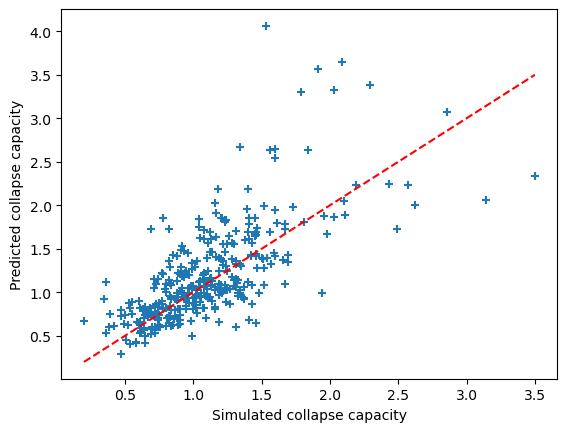

In [29]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

Test set 2

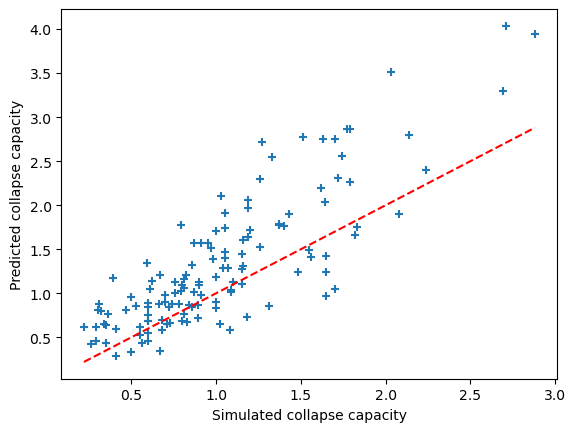

In [30]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

ECDF

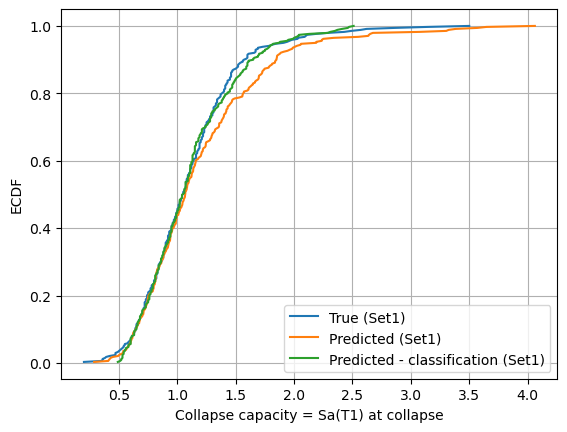

In [31]:
ECDF()

SHAP values

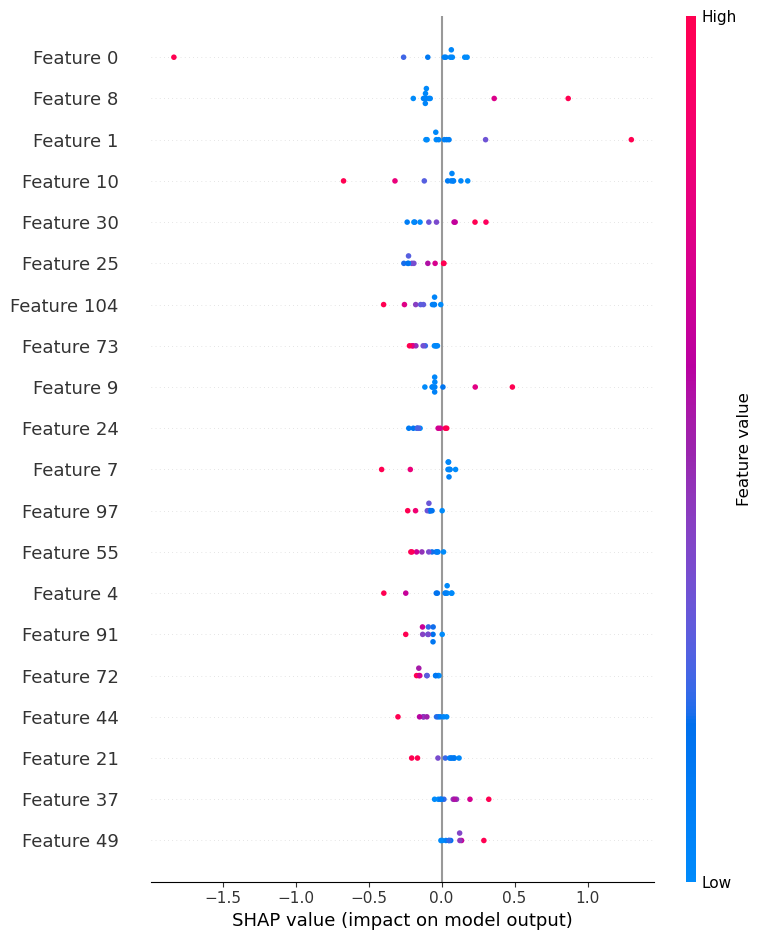

In [32]:
background = X_train_tensor[:88]  # Select a sample from the training set as background
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
X_test_sample = X_test1_tensor[:10]  # Select a sample from the test set
shap_values = explainer.shap_values(X_test_sample)

# Visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test_sample[0])

# Summary plot for the whole test set
shap.summary_plot(shap_values, X_test_sample)

## Gradient Boosting  <a class="anchor" id="gradient-boosting"></a>


In [33]:
from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(42)

random_grid = {
    'n_estimators': [50],
    'max_depth': [3, 5,7,9],
    'learning_rate' : [0.001,0.01,0.1,1],
    'max_features': [0.4,0.5,0.7,0.9,1]
}

gb_model = GradientBoostingRegressor()

grid_search = GridSearchCV(gb_model, random_grid, cv=5)
grid_search.fit(X, y)
best_params_gb = grid_search.best_params_
print(f'Best parameters :{best_params_gb}')

Best parameters :{'learning_rate': 0.1, 'max_depth': 7, 'max_features': 0.4, 'n_estimators': 50}


### Testing

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(**best_params_gb)
gb_model.fit(X, y)

y_pred_test1 = gb_model.predict(X_test1)
y_pred_test2 = gb_model.predict(X_test2)

MSE_Test_GB1 = mean_squared_error(y_test1, y_pred_test1)
MSE_Test_GB2 = mean_squared_error(y_test2, y_pred_test2)

print(f"GB Mean Squared Error test1: {round(MSE_Test_GB1,3)}")
print(f"GB Mean Squared Error test2: {round(MSE_Test_GB2,3)}")

GB Mean Squared Error test1: 0.124
GB Mean Squared Error test2: 0.556


Test set 1

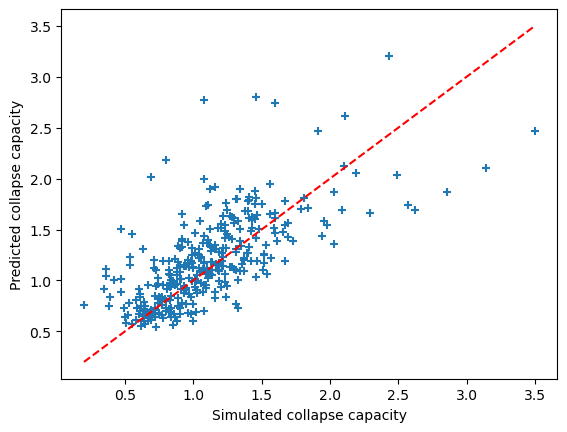

In [35]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

Test set 2

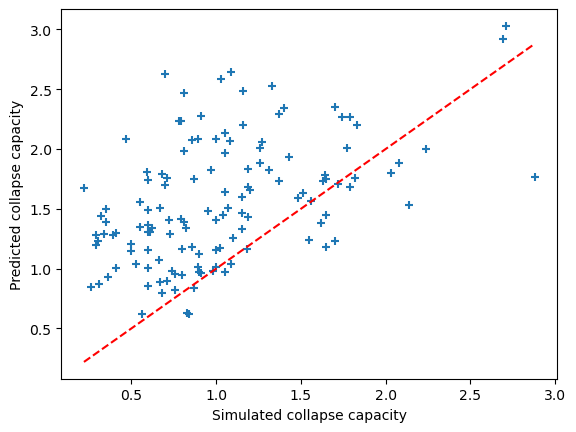

In [36]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

ECDF

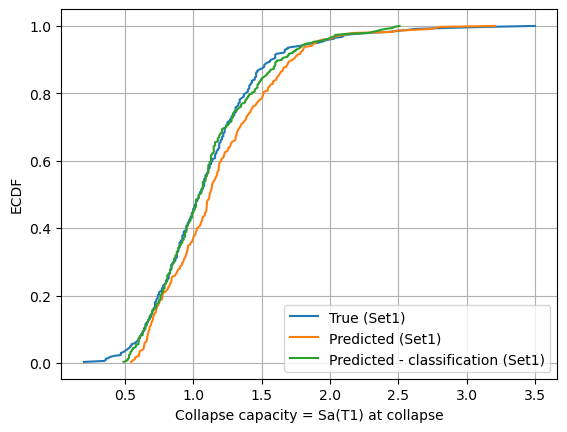

In [37]:
ECDF()

SHAP Values

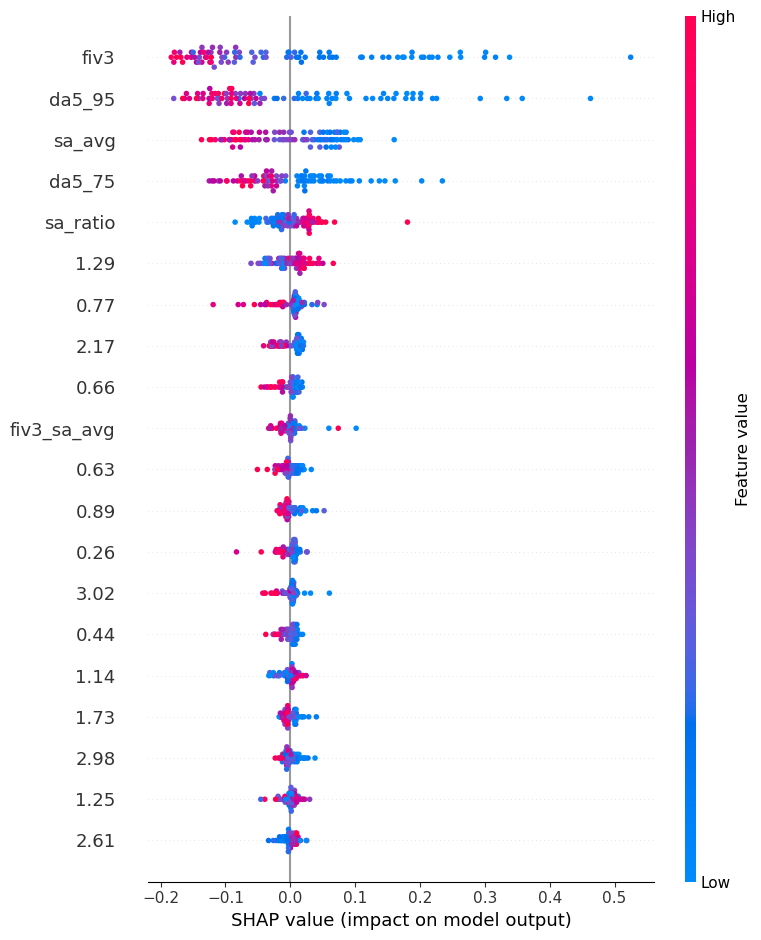

In [38]:
explainer = shap.Explainer(gb_model, X[0:88])
shap_values = explainer(X[0:88])
shap.summary_plot(shap_values)

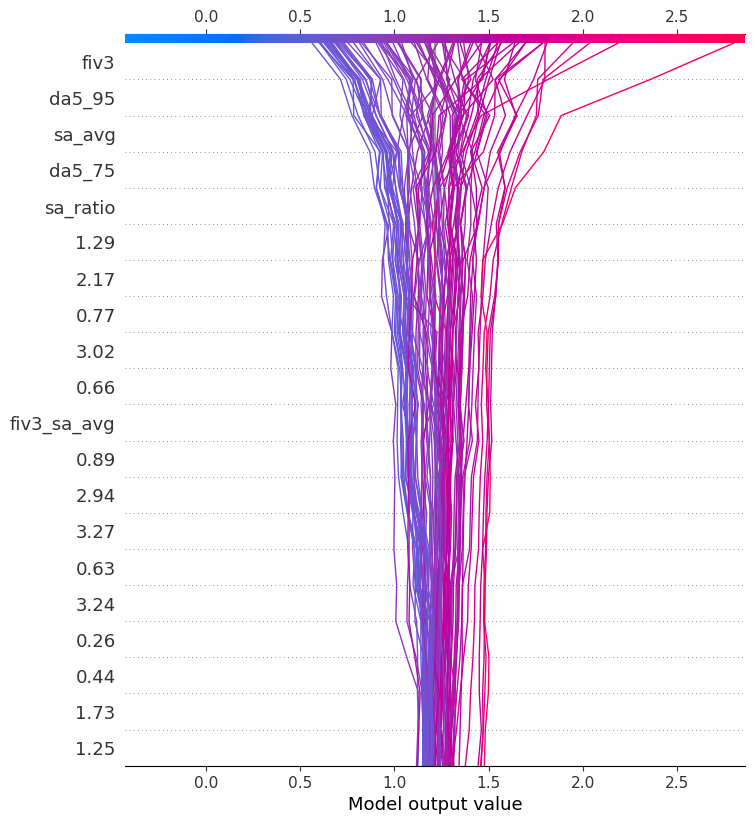

In [39]:
select = range(88)
features = X_test1.iloc[select]
features_display = X_test1.loc[features.index]

expected_values = explainer.expected_value
shap_values = explainer.shap_values(features)

shap.decision_plot(expected_values, shap_values, features_display)

### GB with selected feature set

In [40]:
np.random.seed(42)

random_grid = {
    'n_estimators': [50],
    'max_depth': [3, 5,7,9],
    'learning_rate' : [0.001,0.01,0.1,1],
    'max_features': [0.4,0.5,0.7,0.9,1]
}

gb_model = GradientBoostingRegressor()

columns_to_keep = ['fiv3', '1.29', 'da5_95', '1.44', 'da5_75', 'sa_ratio', 'fiv3_sa_avg']

# Drop every column that is not in the list of columns to keep
X_filtered = X[columns_to_keep]

grid_search = GridSearchCV(gb_model, random_grid, cv=5)
grid_search.fit(X_filtered, y)
best_params_gb2 = grid_search.best_params_
print(f'Best parameters :{best_params_gb2}')

Best parameters :{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.4, 'n_estimators': 50}


### Testing

In [41]:
gb_model = GradientBoostingRegressor(**best_params_gb2)
gb_model.fit(X_filtered, y)

X_test1_filtered = X_test1[columns_to_keep]
X_test2_filtered = X_test2[columns_to_keep]

y_pred_test1 = gb_model.predict(X_test1_filtered)
y_pred_test2 = gb_model.predict(X_test2_filtered)

MSE_Test_GB1 = mean_squared_error(y_test1, y_pred_test1)
MSE_Test_GB2 = mean_squared_error(y_test2, y_pred_test2)

print(f"GB Mean Squared Error test1: {round(MSE_Test_GB1,3)}")
print(f"GB Mean Squared Error test2: {round(MSE_Test_GB2,3)}")


GB Mean Squared Error test1: 0.174
GB Mean Squared Error test2: 0.801


Test set 1

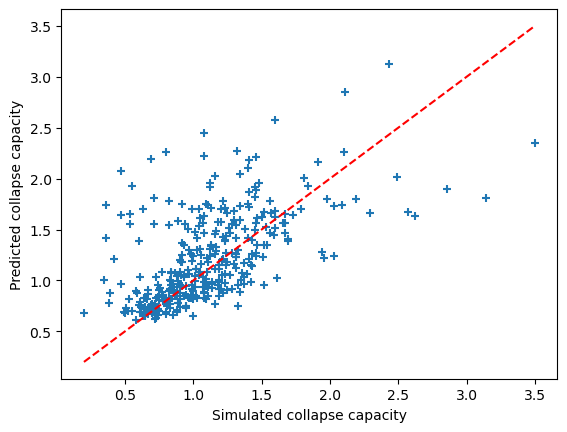

In [42]:
plt.scatter(y_test1,y_pred_test1,marker = "+")
x_line = np.linspace(min(y_test1), max(y_test1), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

Test set 2

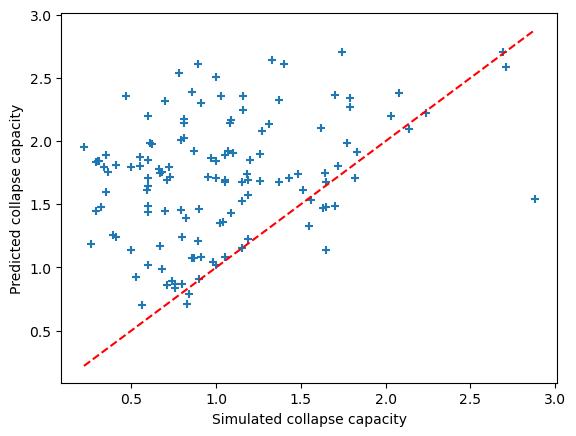

In [43]:
plt.scatter(y_test2,y_pred_test2,marker = "+")
x_line = np.linspace(min(y_test2), max(y_test2), 100)  # Créer une série de points x pour la droite
plt.plot(x_line, x_line, label='y = x', linestyle='--', color='red')
plt.xlabel("Simulated collapse capacity")
plt.ylabel("Predicted collapse capacity")
plt.show()

ECDF

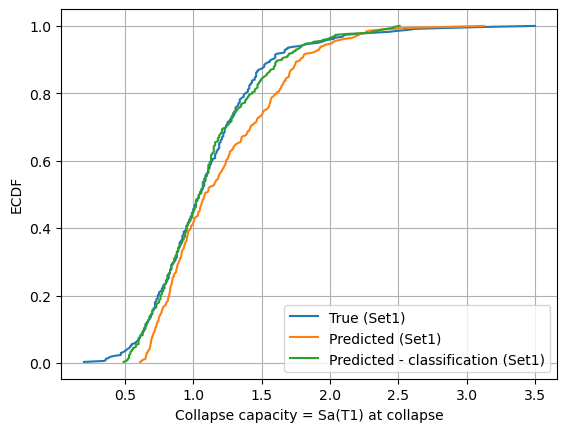

In [44]:
ECDF()

# Results <a class="anchor" id="results"></a>

In [45]:
print(f"RIDGE Mean Squared Error Test1: {round(MSE_Test_RIDGE1,3)}")
print(f"RIDGE Mean Squared Error Test2: {round(MSE_Test_RIDGE2,3)}")
print()
print(f"GB Mean Squared Error Test1: {round(MSE_Test_GB1,3)}")
print(f"GB Mean Squared Error Test2: {round(MSE_Test_GB2,3)}")
print()
print(f"MLP Mean Squared Error Test1: {round(MSE_Test_MLP1,3)}")  
print(f"MLP Mean Squared Error Test2: {round(MSE_Test_MLP2,3)}") 

RIDGE Mean Squared Error Test1: 0.257
RIDGE Mean Squared Error Test2: 0.672

GB Mean Squared Error Test1: 0.174
GB Mean Squared Error Test2: 0.801

MLP Mean Squared Error Test1: 0.169
MLP Mean Squared Error Test2: 0.271
